# Dataset stats

Here, we examine a simulated dataset of ca. 181000 circuits and analyse its basic characteristics.

## Background

A large set of randomly generated RNA circuits was first created as a starting point and the binding energies of all RNAs were determined by the RNA simulator. This list of circuits was then filtered for circuits with a minimum number of 2 interacting species and at least 1 self interacting specie. From these, the first 1000 circuits were chosen as reference circuits. Each was then initialised with a set of mutated versions of itself, where each species was mutated at one of [1, 2, 3, 5, 10, 15] locations on its strand, with 10 variations in total. A reference circuit would thereby have a total of 3 (number of species) * 10 (variations) * 6 (number of mutations within a sequence) = 180 mutated subcircuits. 

Once all the circuits have been determined, their function must be determined. This involved first finding the steady state of the unbound and bound RNA species, then simulating the behavior of the circuit upon being perturbed by a step function. In this case, the step signal was a 2x increase in the species 'RNA_0', which happens instantaneously. In a lab experiment, there are many different ways of implementing this, each with a different delay, so the instantaneous increase presents the most extreme case.

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


from functools import partial
import os
import sys
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from src.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from src.utils.misc.helper import vanilla_return
from src.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs, is_within_range
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.misc.type_handling import flatten_listlike, get_first_elements
from src.utils.misc.string_handling import prettify_keys_for_label
from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from tests_local.shared import CONFIG
from src.utils.common.setup_new import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data

CONFIG = prepare_config(CONFIG)

In [3]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_09_220322/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_09_220322/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_og)

## Distribution of interactions

The minimum free energy (kcal) of binding between each pair of RNA molecules in the circuit is calculated by the RNA simulator. This is then converted into an equilibrium constant through a parameterisation function that was estimated from experimental data (see notebook on calculating binding energies / interactions).

naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING


Text(0.5, 0.98, 'Interaction distributions of\nsource dataset')

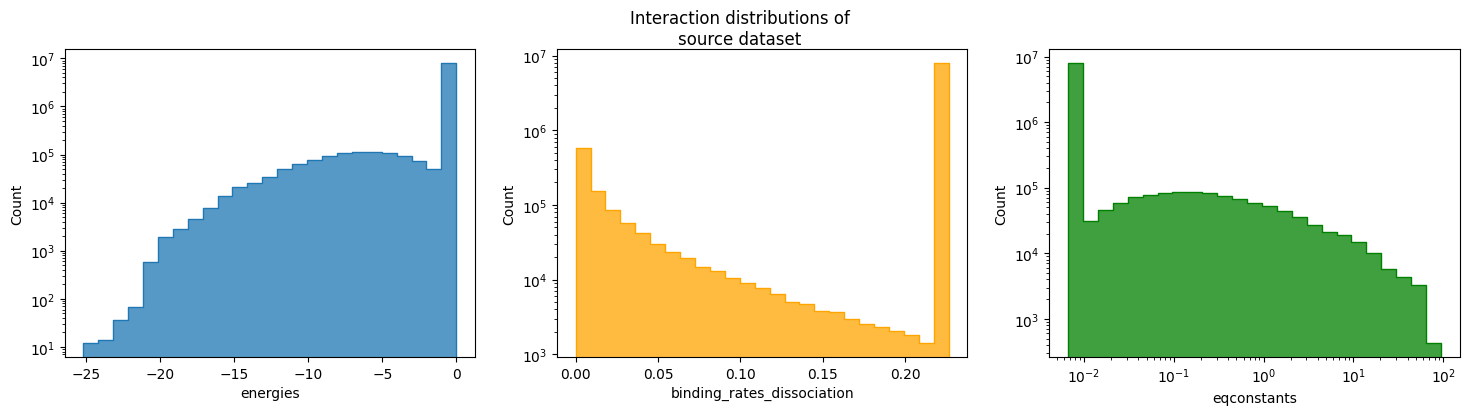

In [4]:
dfm = data.melt(['name'], get_true_interaction_cols(data, 'energies'), value_name='energies', var_name='idx')
dfm1 = data.melt(['name'], get_true_interaction_cols(data, 'binding_rates_dissociation'), value_name='binding_rates_dissociation', var_name='idx')
dfm['binding_rates_dissociation'] = dfm1['binding_rates_dissociation']
dfm1 = data.melt(['name'], get_true_interaction_cols(data, 'eqconstants'), value_name='eqconstants', var_name='idx')
dfm['eqconstants'] = dfm1['eqconstants']
del dfm1

plt.figure(figsize=(18,4))
ax = plt.subplot(1,3,1)
sns.histplot(dfm, x='energies', log_scale=[False, True], element='step')
ax = plt.subplot(1,3,2)
sns.histplot(dfm, x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
ax = plt.subplot(1,3,3)
sns.histplot(dfm, x='eqconstants', log_scale=[True, True], element='step', color='g')

plt.suptitle('Interaction distributions of\nsource dataset')

The distribution of interactions in the dataset that includes all mutations still matches that of the original dataset, from which the 1000 source circuits were chosen.

In [5]:
data = pd.read_csv(fn_mut)

Text(0.5, 0.98, 'Interaction distributions of simulated dataset')

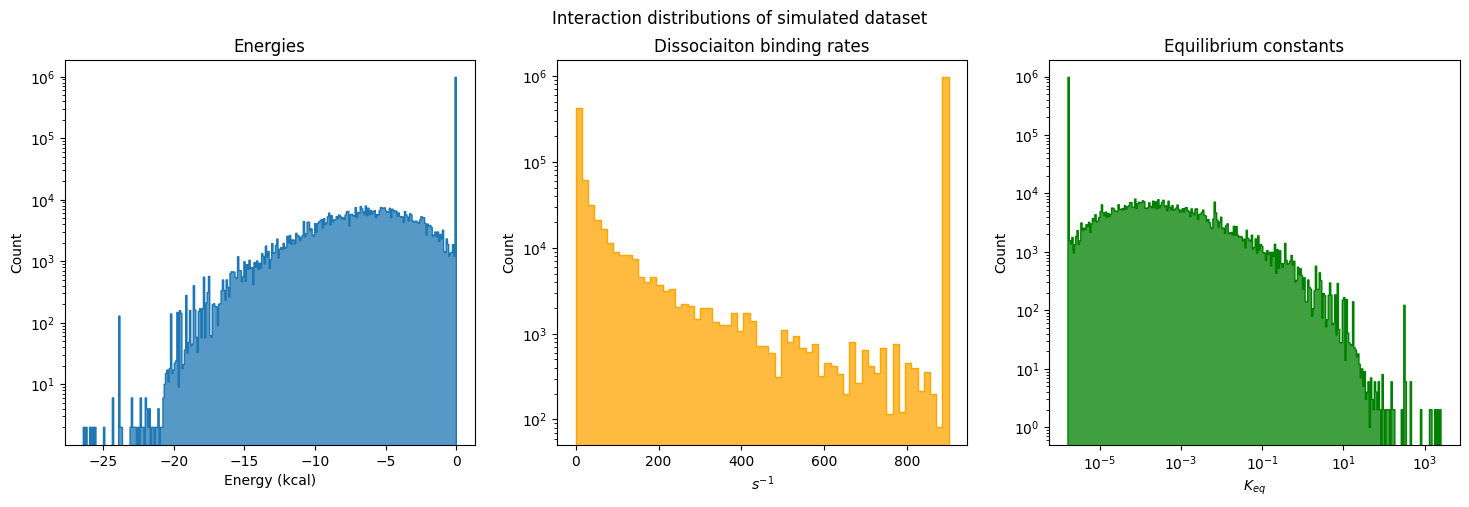

In [6]:
dfm = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'energies'), value_name='energies', var_name='idx')
dfm1 = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'binding_rates_dissociation'), value_name='binding_rates_dissociation', var_name='idx')
dfm['binding_rates_dissociation'] = dfm1['binding_rates_dissociation']
dfm1 = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'eqconstants'), value_name='eqconstants', var_name='idx')
dfm['eqconstants'] = dfm1['eqconstants']
del dfm1

plt.figure(figsize=(18,5))
# ax = plt.subplot(2,3,1)
# sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='energies', log_scale=[False, True], element='step')
# plt.title('Energies: no mutations')
# ax = plt.subplot(2,3,2)
# sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
# plt.title('Dissociaiton binding rates: no mutations')
# ax = plt.subplot(2,3,3)
# plt.title('Equilibrium constants: no mutations')
# sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='eqconstants', log_scale=[True, True], element='step', color='g')

ax = plt.subplot(1,3,1)
sns.histplot(dfm, x='energies', log_scale=[False, True], element='step')
plt.title('Energies')
plt.xlabel('Energy (kcal)')
ax = plt.subplot(1,3,2)
sns.histplot(dfm, x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
plt.title('Dissociaiton binding rates')
plt.xlabel('$s^{-1}$')
ax = plt.subplot(1,3,3)
sns.histplot(dfm, x='eqconstants', log_scale=[True, True], element='step', color='g')
plt.title('Equilibrium constants')
plt.xlabel('$K_{eq}$')

plt.suptitle('Interaction distributions of simulated dataset')

## Example trace of a circuit

In [7]:
def load_fake_circuit(circ_row, config):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        matrix = [[0] * length for _ in range(length)]

        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1

        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')]),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')]),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')]),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')])}
    return construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    

nm = 3
circuits = []
for i in range(3):
    ref_c = data[data['mutation_name'] == 'ref_circuit'].iloc[i]
    mut_c = data[(data['circuit_name'] == ref_c['circuit_name']) & (data['mutation_name'] != 'ref_circuit')].iloc[:nm]
    circuits.append(load_fake_circuit(circ_row=ref_c, config=CONFIG))
    for mi in range(len(mut_c)):
        circuits.append(load_fake_circuit(circ_row=mut_c.iloc[mi], config=CONFIG))


xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter Host INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


In [8]:
# * here we have an example of 2 reference steady state circuits and their mutations plotted in a row of 2 and columns of 4 *

In [16]:

forward_rates = circuits[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])


t0 = 0 
t1 = 200
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits[0].signal.reactions_onehot) if circuits[0].use_prod_and_deg else np.zeros_like(circuits[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits[0].qreactions.reactions.inputs,
                            outputs=circuits[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, int(np.min([200, t1-t0]))))
                            )))

In [23]:

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, t1 = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)


Done:  0:00:33.290945


In [30]:
signal_species_idx = 6

b_steady_states = b_copynumbers[:, :, -1]
b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0]

b_new_copynumbers, t2 = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates,
    dt0=np.repeat(dt, repeats=reverse_rates.shape[0]))

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

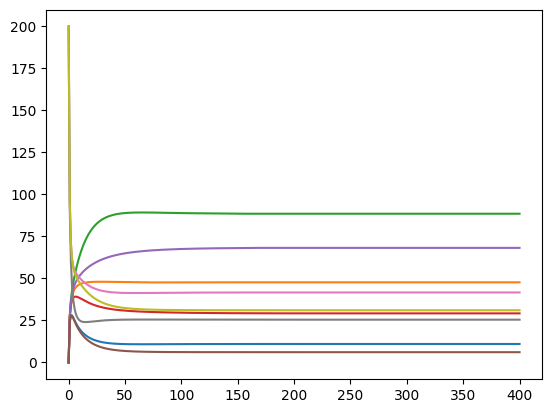

In [ ]:
plt.plot(np.concatenate([t1, t2 + t1[-1]]), np.concatenate([b_steady_states[0].T, b_new_copynumbers[0].T]))

plt.plot(t1[-1])